In [1]:
from astropy.io import fits 
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
fits_file = fits.open("/home/milic/scratch/FISS_20160625_181531_A1.fts")
fits_file.info()

Filename: /home/milic/scratch/FISS_20160625_181531_A1.fts
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      38   (512, 256, 120)   int16   


In [5]:
fits_file[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  512 / length of data axis 1                          
NAXIS2  =                  256 / length of data axis 2                          
NAXIS3  =                  120 / length of data axis 3                          
DATE    = '2016-06-25T18:15:31' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
EXPTIME =                 0.02 / Second                                         
HBINNING=                    1                                                  
VBINNING=                    2                                                  
EMGAIN  =                    0 / Value Range: 0-255                             
STRTIME = '2016.06.25-18:15:16' / Scan Start Time                               
ENDTIME = '2016.06.25-18:15:

In [6]:
spectra = fits_file[0].data
print (spectra.shape)

(120, 256, 512)


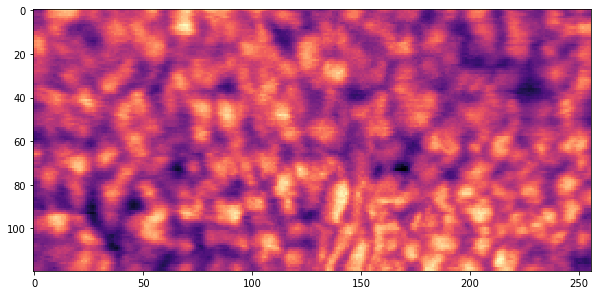

In [7]:
plt.figure(figsize=[10,7])
plt.imshow(spectra[:,:,0],cmap='magma')

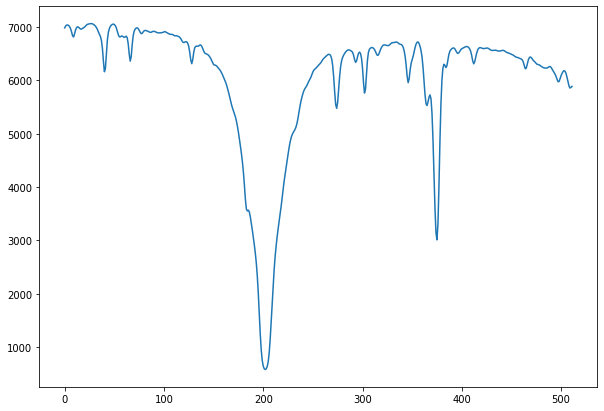

In [8]:
mean = np.mean(spectra,axis=(0,1))
plt.figure(figsize=[10,7])
plt.plot(mean)

In [9]:
from scipy.signal import argrelextrema
mins = argrelextrema(mean, np.less)
print (mins) 

(array([  9,  16,  40,  56,  60,  66,  77,  86,  95, 106, 111, 120, 128,
       134, 184, 202, 274, 293, 302, 315, 326, 346, 365, 375, 384, 396,
       412, 422, 431, 438, 464, 485, 497, 509]),)


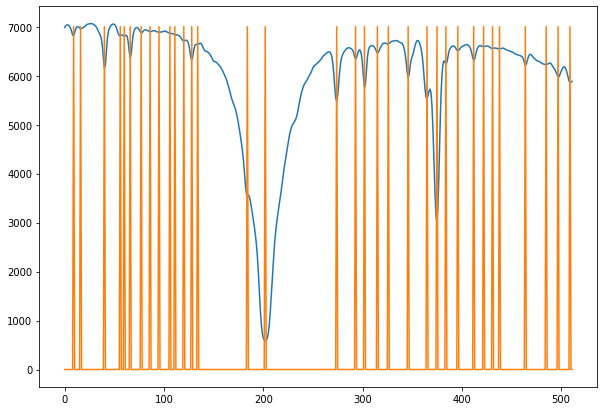

In [10]:
plt.figure(figsize=[10,7])
minima = np.zeros(512)
minima[mins] = 7000.0
plt.plot(mean)
plt.plot(minima)

First let's note the indices of the three well separated spectal lines, say: 40, 202, 375

Let's now find three lines from the atlas that we can use to calibrate our wavelength grid. 

http://bass2000.obspm.fr/download/solar_spect.pdf

It seems like the first one, and all the other nearby ones are atmospheric, so we can't use them. Can someone tell me why?

.
.
.
.
.
.
Ok, let's use only the latter two ones. These are Na I around 5890 and Ni I around 5893. Around is not good enough. Let's either use Atlas or the NIST database. I love NIST and we live in Boulder so I will use NIST. 


In [11]:
n1 = 202.0
n2 = 375.0
l1 = 5889.95095
l2 = 5892.88
slope = (l2-l1)/(n2-n1)
intercept = l1 - n1*slope
print (slope, intercept)

0.01693092485548979 5886.530903179191


Similar to what fits file says! 

In [13]:
ll = np.linspace(0,511,512)
ll = ll[:] * slope + intercept

In [15]:
atlas = np.loadtxt("/home/milic/scratch/5890_atlas.txt",unpack=True)
print (atlas.shape)

(2, 5001)


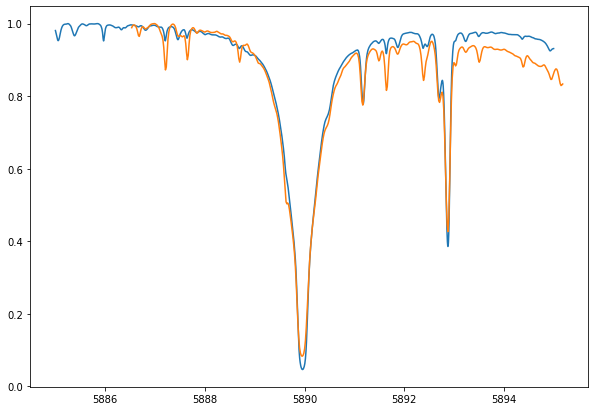

In [16]:
plt.figure(figsize=[10,7])
plt.plot(atlas[0],atlas[1]/np.amax(atlas[1]))
plt.plot(ll,mean/np.amax(mean))

Ok so now let's try and calculate some plasma velocities from this. Should be fun! 

In [19]:
NX = spectra.shape[0]
NY = spectra.shape[1]
v_na = np.zeros([NX,NY])
v_ni = np.zeros([NX,NY])

In [35]:
def calculate_velocity (spectrum,ll,left,right,center_wvl):
    pixel_min = np.argmin(spectrum[left:right])
    v = (ll[pixel_min+left] - center_wvl) / center_wvl * 2.997E5 # in km
    return v
    

In [36]:
for i in range(0,NX):
    for j in range(0,NY):
        v_na[i,j] = calculate_velocity(spectra[i,j],ll,180,220,l1)
        v_ni[i,j] = calculate_velocity(spectra[i,j],ll,355,395,l2)

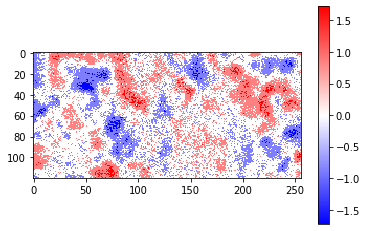

In [39]:
plt.plot(figure=[10,7])
plt.imshow(v_na,cmap='bwr')
plt.colorbar()

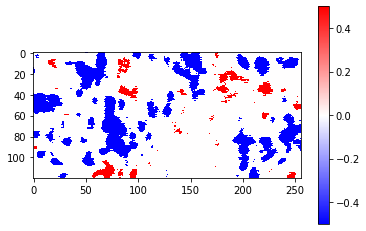

In [41]:
plt.plot(figure=[10,7])
plt.imshow(v_ni,cmap='bwr',vmin=-0.5,vmax=0.5)
plt.colorbar()

In [42]:
def calculate_velocity_pr0 (spectrum,ll,left,right,center_wvl):
    p = np.polyfit(ll[left:right],spectrum[left:right],2)
    ll_min = -p[1]/2./p[0]
    v =(ll_min - center_wvl)/center_wvl * 2.997E5
    return v

In [48]:
for i in range(0,NX):
    for j in range(0,NY):
        v_na[i,j] = calculate_velocity_pr0(spectra[i,j],ll,197,207,l1)
        v_ni[i,j] = calculate_velocity_pr0(spectra[i,j],ll,372,378,l2)

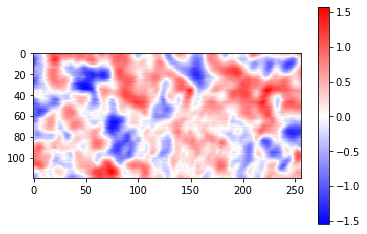

In [52]:
plt.plot(figure=[13,7])
plt.imshow(v_na,cmap='bwr')
plt.colorbar()

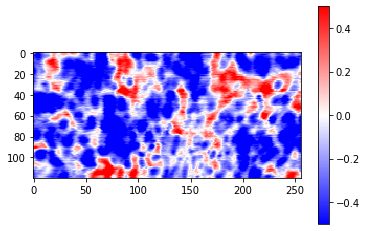

In [53]:
plt.plot(figure=[13,7])
plt.imshow(v_ni,cmap='bwr',vmin=-0.5,vmax=0.5)
plt.colorbar()